In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from time import process_time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor

import psutil

# def MAPE2(actual_values, predicted_values):
#     mape = np.mean(np.abs(np.where(np.logical_and(actual_values != 0, predicted_values != 0), (actual_values - predicted_values) / (actual_values + 1e-10), (actual_values - predicted_values) / 100)))
#     return mape

def MAPE(actual_values, predicted_values):
    mape_sum = 0.0
    count = 0

    for actual, predicted in zip(actual_values, predicted_values):
        if actual != 0 and predicted != 0:
            mape_sum += abs((actual - predicted) / actual)
        else:
            mape_sum += abs(actual - predicted) / 100
        count += 1

    if count == 0:
        return 0  # Handle the case when there are no valid entries to avoid division by zero.

    return (mape_sum / count)[0]

In [50]:
df1M = pd.DataFrame(np.loadtxt('./intersect.filter.csv', delimiter=','))
df1M.head() # show the first 5 rows

,0,1,2,3,4
0,-122.0,-37.0,-59.0,-24.0,49019.0
1,-166.0,-62.0,-139.0,-43.0,1040.0
2,99.0,30.0,115.0,68.0,66507.0
3,-159.0,-77.0,-112.0,-62.0,1041.0
4,-63.0,50.0,-3.0,66.0,68350.0


In [51]:
data = np.loadtxt('./intersect.filter.csv', delimiter=',')
Rectangles = data[:,0:4]
Rectangles.shape

(999999, 4)

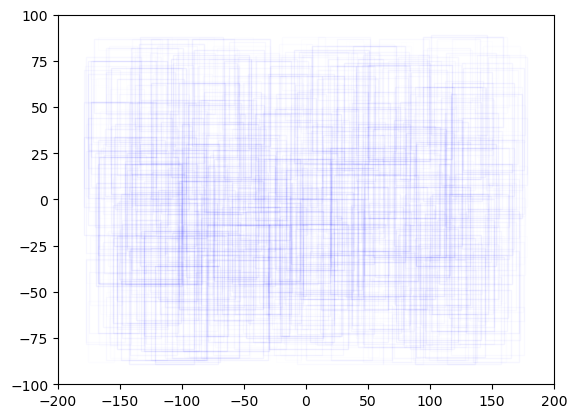

In [52]:
univ_xmin = -180
univ_xmax = 180
univ_ymin = -90
univ_ymax = 90
Surface_univ=(univ_xmax-univ_xmin)*(univ_ymax-univ_ymin)

s=0
rectanglesDensity = []
for i in Rectangles:
    s = abs((i[3]-i[1])*(i[2]-i[0])/Surface_univ)
    rectanglesDensity.append(s)
rectanglesDensity = np.array(rectanglesDensity)


# Plot 1000 rectangles from x1, y1 to x2, y2
ax = plt.subplot()
for rect, color in zip(Rectangles[0:1000], rectanglesDensity[0:1000]):
    x1, y1, x2, y2 = rect
    rectangle = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='b', facecolor='none', alpha=color)
    ax.add_patch(rectangle)
# The next code show the real rectangles forms with the color of the density
# plt.xlim(min(rect[0] for rect in Rectangles), max(rect[0] for rect in Rectangles))
# plt.ylim(min(rect[1] for rect in Rectangles), max(rect[1] for rect in Rectangles))
plt.xlim(-200, 200)
plt.ylim(-100, 100)
plt.show()

In [53]:
# Prepare data for the models the input is X and the output is Y
Y = data[:,4:5]
rectanglesDensity = rectanglesDensity.reshape(rectanglesDensity.shape[0],1)
X = np.append(data[:,0:4], rectanglesDensity, axis=1)
# X = data[:,0:4]

# Split the data into 80% train and 20% test
X_train, X_test_all, y_train, y_test_all = train_test_split(X, Y, test_size=0.2, random_state=3)


# Taking just 1k first data
sample_size = 800000
X_train = X_train[:sample_size,:]
y_train = y_train[:sample_size]
# X_sample = X_sample[:sample_size,:]
# Y_sample = Y_sample[:sample_size]

Y.shape # (999999, 1)
X.shape # (999999, 5)


columns = ['x_min','y_min','x_max','y_max','Density']
# columns = ['x_min','y_min','x_max','y_max']
Data_Set = pd.DataFrame(data=X,columns=columns)
column = ['number_of_objets']
Target = pd.DataFrame(data=Y,columns=column)

# Split the data into 80% train and 20% test
# X_train, X_test, y_train, y_test = train_test_split(X_sample, Y_sample, test_size=0.2, random_state=3)

# Max, min, mean and median
print("Max :", np.max(Y))
print("Min :", np.min(Y))
print("Mean :", np.mean(Y))
print("Median :", np.median(Y))


Max : 1683002.0
Min : 2.0
Mean : 172835.6677046677
Median : 65194.0


In [54]:
# Optimize KNN with GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define a range of n_neighbors values to test (from 1 to 15)
param_grid = {'n_neighbors': np.arange(1, 15)}

# Create a KNN model
knn = KNeighborsRegressor()

# Perform grid search using cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_median_absolute_error')
t1_start = process_time()
grid_search.fit(X_train, y_train)
t1_stop = process_time()
print("Elapsed time during the learning and tuning phase in seconds (KNN):", t1_stop-t1_start, "s")

# Get the best hyperparameters
best_n_neighbors = grid_search.best_params_['n_neighbors']
print("Best N neighbors number is :", best_n_neighbors)

Elapsed time during the learning and tuning phase in seconds (KNN): 383.88283086700005 s
Best N neighbors number is : 8


In [55]:
from sklearn.model_selection import cross_val_score

# Create a KNN model with the best hyperparameters
best_knn = KNeighborsRegressor(n_neighbors=best_n_neighbors)

# Perform cross-validation to evaluate the model
mse_scores = cross_val_score(best_knn, X_train, y_train, cv=5, scoring='neg_median_absolute_error')

# Calculate the mean squared error
rmse_scores = np.sqrt(-mse_scores)
rmse_scores

array([48.01497162, 47.99283801, 47.9426741 , 47.97134561, 47.81213235])

Elapsed time during the learning phase in seconds (KNN): 1.875582344999998 s
Mean absolute error of 20% of all: 6563.43
Mean absolute percentage error of 20% of all: 8.47%
I/O Operations (mean of 10 times) - Reads: 0.0, Writes: 0.0001925
Elapsed time during one estimation in seconds (mean of 10 times): 3.304978665050009e-05
Elapsed time during one estimation in microseconds (mean of 10 times): 33.04978665050009


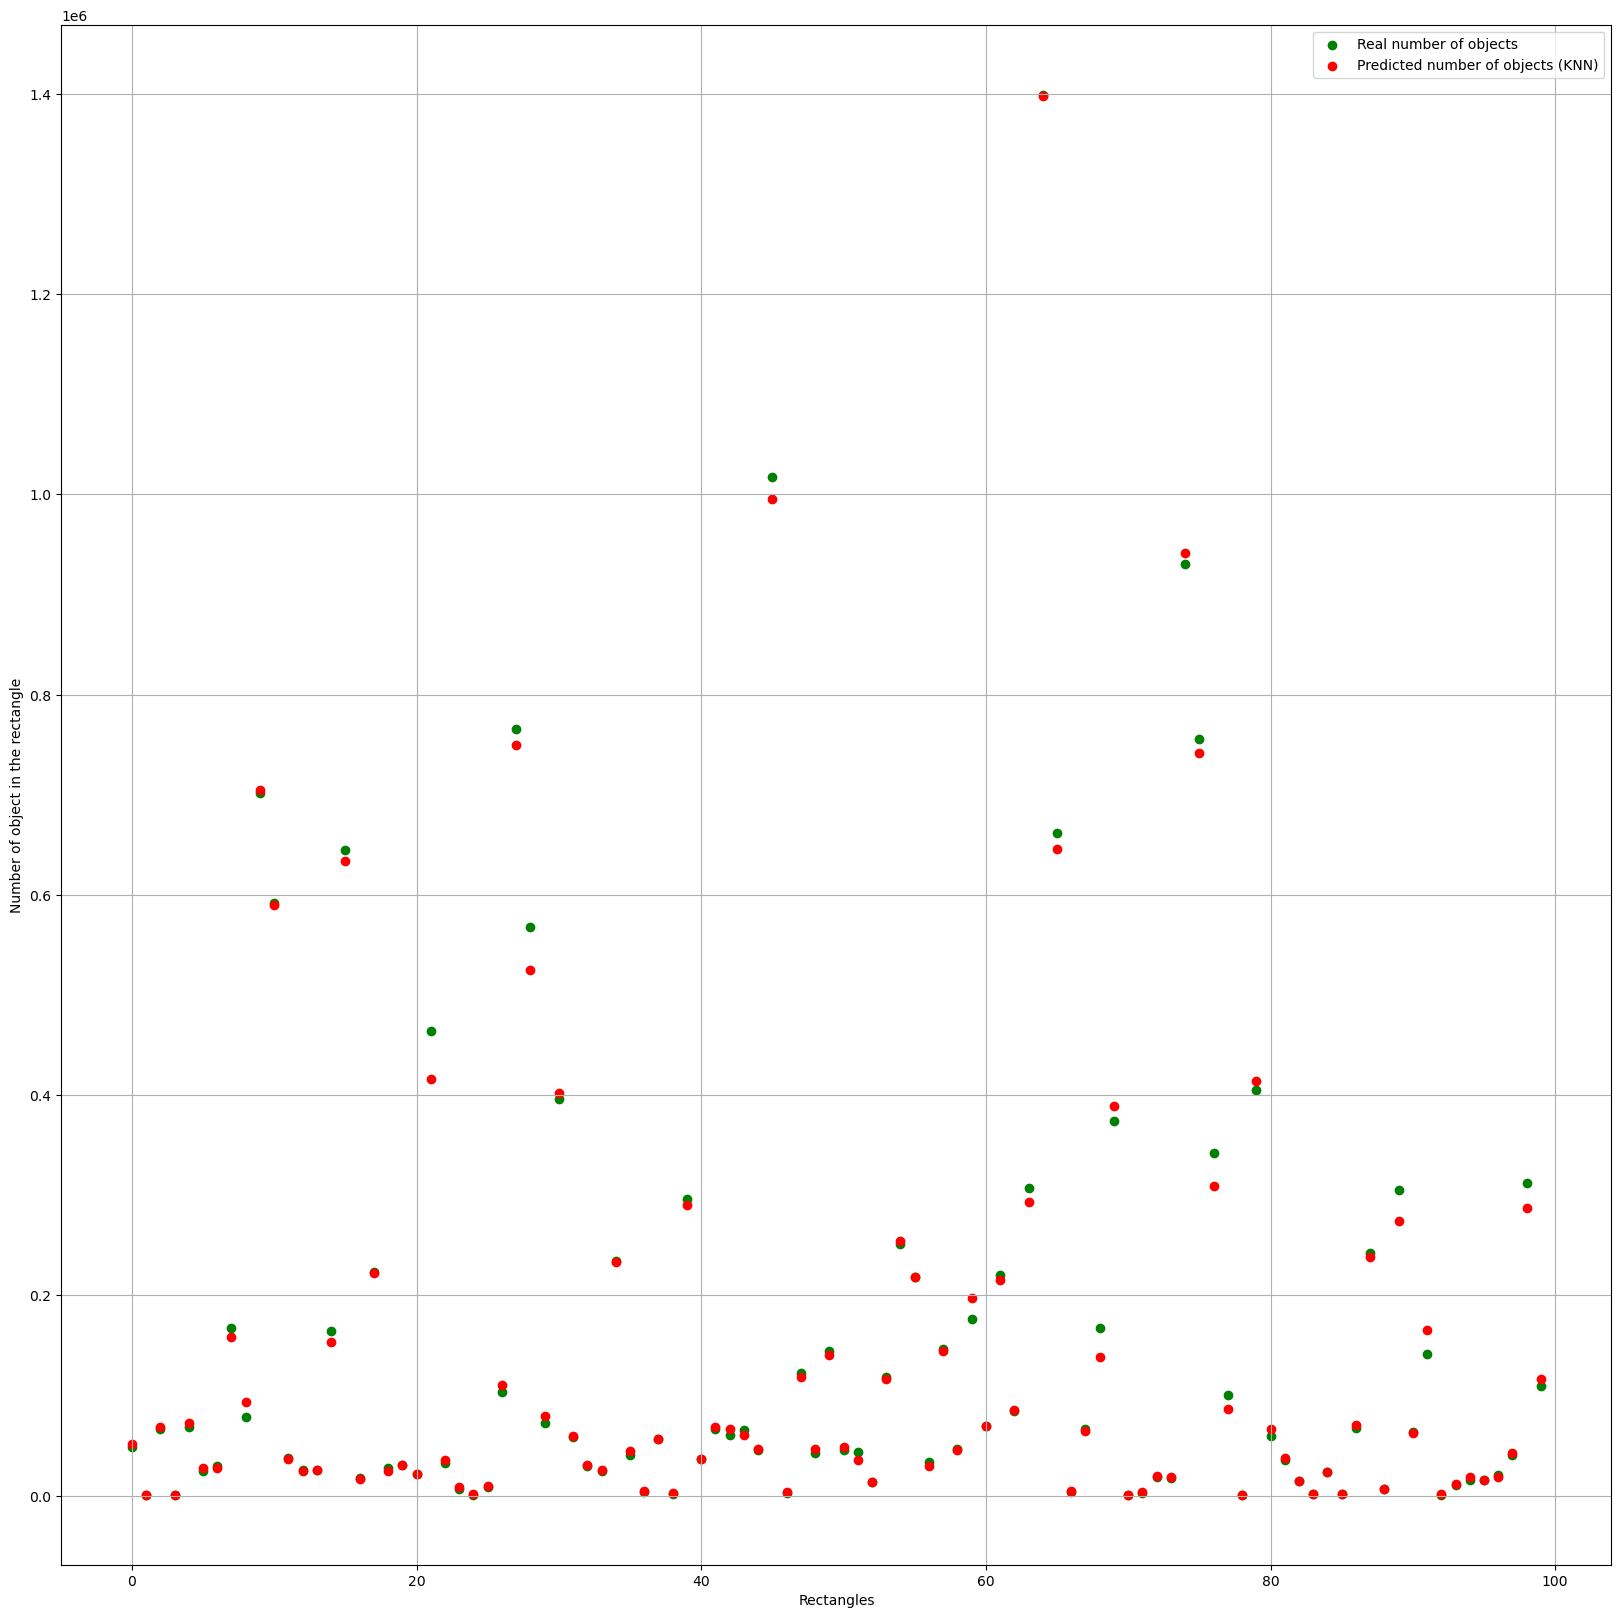

,Real number of objects,Predicted number of objects (KNN)
0,49019.0,51828.750
1,1040.0,955.125
2,66507.0,68569.125
3,1041.0,1040.500
4,68350.0,72378.125
...,...,...
95,16121.0,16109.125
96,20612.0,18457.625
97,40249.0,42901.875
98,312721.0,287025.625


In [56]:
# KNN with GridSearchCV

# Create a scatter plot for the real number of objects
Y[:100]
t1_start = process_time()
best_knn.fit(X_train, y_train)
t1_stop = process_time()
print("Elapsed time during the learning phase in seconds (KNN):", t1_stop-t1_start, "s")

import pickle
filename = f'./LearnedModels/KNN/KNN_{sample_size}_{(t1_stop-t1_start):.2f}s_{MAPE(y_test_all, best_knn.predict(X_test_all)):.2%}_{MAE(y_test_all, best_knn.predict(X_test_all)):.2f}.sav'
pickle.dump(best_knn, open(filename, 'wb'))

# Score of KNN with GridSearchCV
# maeKNN = MAE(y_test, best_knn.predict(X_test))
# print(f"Mean absolute error of KNN: {maeKNN}")
# mapeKNN = MAPE(y_test, best_knn.predict(X_test))
# print(f"Mean absolute percentage error of the KNN Regressor with GridSearchCV: {mapeKNN:.2%}")
print(f"Mean absolute error of 20% of all: {MAE(y_test_all, best_knn.predict(X_test_all)):.2f}")
print(f"Mean absolute percentage error of 20% of all: {MAPE(y_test_all, best_knn.predict(X_test_all)):.2%}")

# Time to predict calculated 10 times and the average is calculated
total_duration = 0
total_read = 0
total_write = 0
for i in range(10):
    io_before = psutil.disk_io_counters()
    t1_start = process_time()
    y_pred_tmp = best_knn.predict(X_test_all)
    t1_stop = process_time()
    io_after = psutil.disk_io_counters()
    total_duration += (t1_stop-t1_start)
    total_read += io_after.read_count - io_before.read_count
    total_write += io_after.write_count - io_before.write_count

print(f"I/O Operations (mean of 10 times) - Reads: {total_read/10/len(y_pred_tmp)}, Writes: {total_write/10/len(y_pred_tmp)}")
print("Elapsed time during one estimation in seconds (mean of 10 times):", (total_duration/10)/len(y_pred_tmp))
print("Elapsed time during one estimation in microseconds (mean of 10 times):", (total_duration/10)/len(y_pred_tmp)*1000000)

# Create a scatter plot for the predicted number of objects by Decision Tree compared to the real number of objects
plt.figure(figsize=(20, 20))
plt.scatter(range(100), Y[:100], c='green', label='Real number of objects')
plt.scatter(range(100), best_knn.predict(X[:100]), c='red', label='Predicted number of objects (KNN)')
plt.xlabel('Rectangles')
plt.ylabel('Number of object in the rectangle')
plt.legend()
plt.grid()
plt.show()

# Show the same plot data in a table
real_values = Y[:100].ravel()
predicted_values = best_knn.predict(X[:100]).ravel()
df = pd.DataFrame({'Real number of objects': real_values, 'Predicted number of objects (KNN)': predicted_values})
df